# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.495197,False,0.087986
1,-1.581686,False,-1.721369
2,-1.768629,False,-4.145863
3,0.061654,True,5.126225
4,0.334663,True,4.190167
...,...,...,...
995,-1.643208,False,-4.531094
996,-0.238074,True,5.669158
997,0.604310,False,1.605504
998,-0.278361,False,-3.861634


<AxesSubplot: xlabel='v0'>

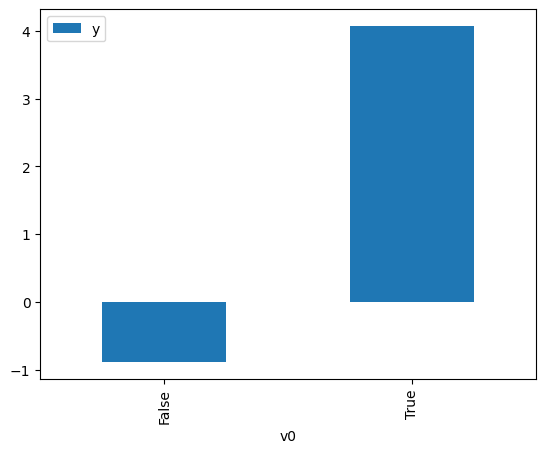

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

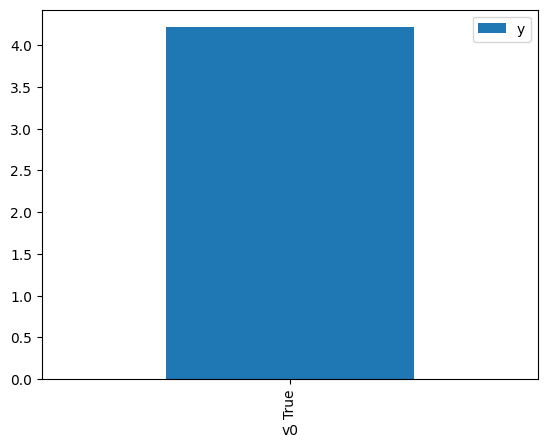

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.309961,False,0.575107,0.651282,1.535433
1,-0.983459,False,-1.226533,0.885595,1.129185
2,-0.502504,False,-0.662604,0.737141,1.356593
3,-0.508891,False,-2.520529,0.739745,1.351817
4,-0.236352,False,0.033590,0.615214,1.625451
...,...,...,...,...,...
995,0.507412,False,1.276103,0.249573,4.006839
996,-2.195287,False,-4.776804,0.990096,1.010004
997,-1.561450,False,-4.225458,0.963269,1.038131
998,-0.864832,False,-0.285299,0.857670,1.165949


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.090766,True,3.938671,0.459605,2.175782
1,-2.028639,True,-0.433346,0.014022,71.316376
2,0.760238,True,7.724513,0.836803,1.195024
3,0.812503,True,6.873988,0.851317,1.174650
4,-0.582990,True,3.307252,0.231284,4.323690
...,...,...,...,...,...
995,-2.028639,True,-0.433346,0.014022,71.316376
996,0.780936,True,6.487420,0.842683,1.186686
997,-0.870783,True,3.379852,0.140803,7.102140
998,0.941639,True,5.729149,0.882632,1.132975


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              9259.
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:54:39   Log-Likelihood:                         -1419.1
No. Observations:                1000   AIC:                                      2842.
Df Residuals:                     998   BIC:                                      2852.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2726      0.031     74.038      0.000       2.212       2.333
x2             5.0261      0.052     95.894      0.000       4.923       5.129
==============================================================================
Omnibus:                        3.238   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.090
Skew:                          -0.122   Prob(JB):                        0.213
Kurtosis:                       3.119   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""